In [1]:
#!pip install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time
import cv2
import pandas as pd
import math
import random

import tensorflow as tf
print(tf.__version__)

from keras.applications import EfficientNetB0
from keras.models import Model, Sequential
from keras import layers
from keras import callbacks

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import funcs as f
import im_utils

2.16.2


In [3]:
#from keras.callbacks import EarlyStopping
class CustomStopper(callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=5, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [4]:
SIZE = 254 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [5]:
path = './branded/'
#os.system(f"aws s3 cp {'s3://open-logo-s3/branded/'} {path} --recursive")  

#### Read the file names and labeles

In [6]:
# this list holds all the image filename
boxes_file_paths = []
labels = []

# reads paths for each image and stores it in the array, also stores the label in a separate array
for path_tuple in os.walk(path):
    for file in path_tuple[2]:
        if file.endswith(".jpg"):
            boxes_file_paths.append(os.path.join(path_tuple[0], file))
            labels.append(path_tuple[0].split('/')[-1])

#### Prepare a dataframe of filenames and labels

In [7]:
# Convert labels to dataframe
lbl_df = pd.DataFrame(labels, columns=['label'])

# Get a new data frame with the counts of each lable
counts = lbl_df.groupby('label').value_counts().sort_values(ascending=False).to_frame()
counts['brand_name'] = counts.index

In [8]:
# Get the brand info from the datbase
import db_ops
query = f'''
SELECT *
FROM brand
ORDER BY brand_name DESC
'''
brand_df = db_ops.select_to_pandas(query, True, True)

Connecting to the PostgreSQL database...
Connection successful


/home/ubuntu/workspace/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [9]:
counts = counts.set_index('brand_name').join(brand_df.set_index('brand_name')).sort_values('brand_name')
counts['idx'] = range(len(counts))

In [10]:
counts.to_csv('brand_ids_idx.csv', sep = '\t')
counts.sort_values('count', ascending=False).head(50)

,count,brand_id,score,idx
brand_name,,,,
zz_unbranded,1235,304,0.00000,223
corona,977,32,36.38350,46
heineken,892,53,21.66269,84
modelo,386,71,4.58534,125
bud_light,256,137,0.00000,26
coca_cola,135,29,3.77853,43
pepsi,89,81,1.53629,150
red_bull,71,83,1.26399,163
gatorade,66,47,2.94483,71


In [11]:
# Associate uniqe numeric index with the brand and, consequently, the file
lbl_df['idx'] = lbl_df['label'].apply(lambda x: counts['idx'].loc[x])

# Add the path to the df
lbl_df['file_path'] = boxes_file_paths

# Shuffle the dataframe
lbl_df = lbl_df.sample(frac=1).reset_index(drop=True)

# Get a dataframe with a list of all paths for each label
new_df = lbl_df.groupby('idx')['file_path'].apply(list).reset_index()
new_df.head(3)

,idx,file_path
0,0,[./branded/100_grand/ordered_1106_ordered_1885...
1,1,"[./branded/1800/ordered_1553_im.jpg202.jpg, ./..."
2,2,[./branded/3_musketeers/ordered_131_ordered_19...


In [12]:
# Set the number of categories
num_classes = len(counts)
num_classes

224

#### Read the files/labels and convert them into the right shape

In [13]:
# Make validation set, with very low augmentation level, just enough to have a couple of images for each brand

X = []
y_dense = []
for idx in range(len(new_df)):
    counter = 0
    for file_path in new_df['file_path'].iloc[idx]:
        # Read the image
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img = im_utils.resize_to_size(img_orig, SIZE)
        img = im_utils.crop_to_square(img)
        X.append(img)
        y_dense.append(idx)
        counter += 1
    while counter < 5:
        # Select a random image for this index
        img_index = random.randint(0, len(new_df['file_path'].iloc[idx])-1)
        file_path = new_df['file_path'].iloc[idx][img_index]
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        # Roatate this image by a random angle
        angle = random.randint(1, 180)
        img = im_utils.rotate_and_crop(img_orig, angle)
        # Randomly change the brightness of this image
        brightness = 10 * random.randint(0, 20) # Need sizable change, no less than 10 points
        img = im_utils.jitter_brightness(img, brightness )
        X.append(img)
        y_dense.append(idx)
        counter += 1


X = np.array(X)
X.shape

y = to_categorical(y_dense, num_classes=num_classes)
y.shape

# Split the resulting set, but only keep the validation part
_, X_val, _, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [14]:
# Make training set, with very high augmentation level
# We can not use this set for validation though

X = []
y_dense = []
for idx in range(len(new_df)):
    counter = 0
    for file_path in new_df['file_path'].iloc[idx]:
        # Read the image
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img = im_utils.resize_to_size(img_orig, SIZE)
        img = im_utils.crop_to_square(img)
        X.append(img)
        y_dense.append(idx)
        counter += 1
    while counter < 200:
        # Select a random image for this index
        img_index = random.randint(0, len(new_df['file_path'].iloc[idx])-1)
        file_path = new_df['file_path'].iloc[idx][img_index]
        img_orig = cv2.imread(file_path, cv2.IMREAD_COLOR)
        # Roatate this image by a random angle
        angle = random.randint(1, 180)
        img = im_utils.rotate_and_crop(img_orig, angle)
        # Randomly change the brightness of this image
        brightness = 10 * random.randint(0, 20) # Need sizable change, no less than 10 points
        img = im_utils.jitter_brightness(img, brightness )
        X.append(img)
        y_dense.append(idx)
        counter += 1


X = np.array(X)
X.shape

y = to_categorical(y_dense, num_classes=num_classes)
y.shape

# Split the resulting set, but only keep the validation part
X_train, _, y_train, _  = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [15]:
# Create a TensorFlow Dataset from these two datasets
# This way we get the validation dataset very close to original, and training with lots of augmentation
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2024-07-01 03:37:16.393819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 03:37:16.398385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 03:37:16.401319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Read the labels

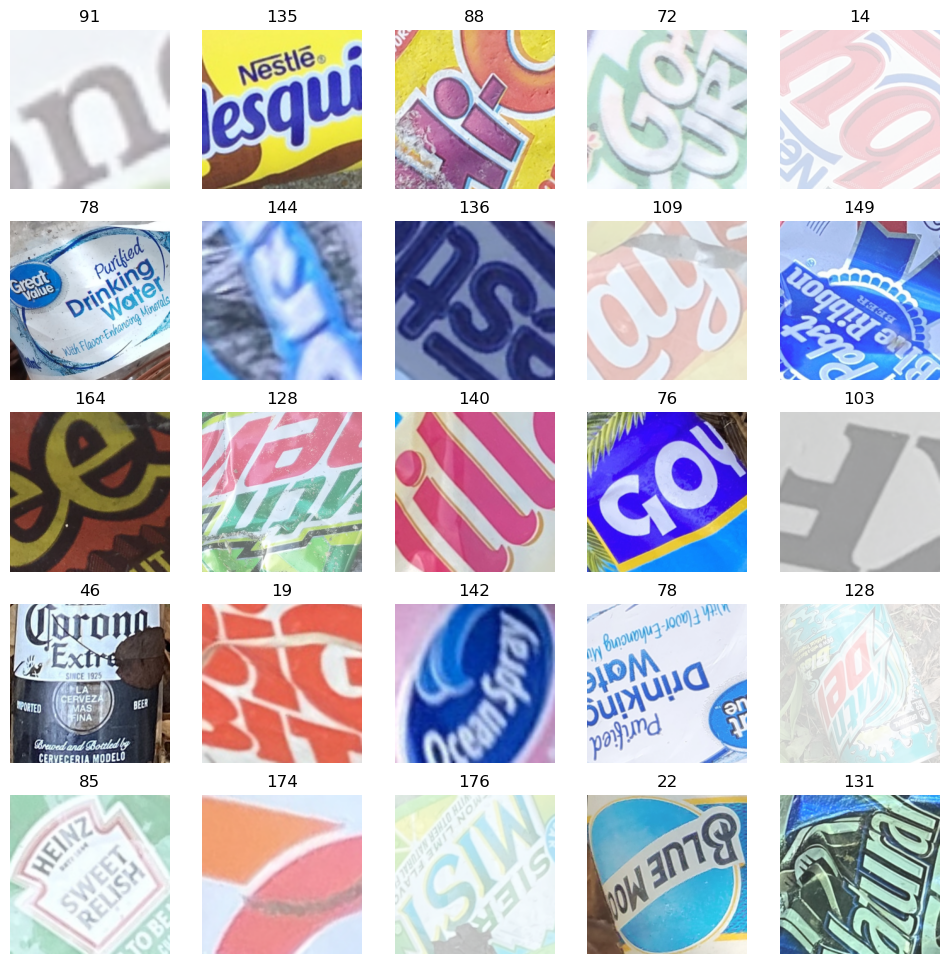

In [16]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    axs[i,j].imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_dense[idx])
    axs[i,j].axis('off')

plt.show()

# Make sure all images are square, undistorted, labels make sense

In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    EffNet_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    EffNet_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(EffNet_model.output)
    x = layers.BatchNormalization(name="batch_norm")(x)
    x = layers.Dense(4*num_classes, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

early_stopping = CustomStopper()

In [18]:
#Define the model
model = build_model(num_classes)

In [19]:
# Train the model with the early stopping callback
print("Training model...")
start_time = time.time()
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Training model...
Epoch 1/100


I0000 00:00:1719805059.795963    4302 service.cc:145] XLA service 0x7abbe40025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719805059.796001    4302 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-01 03:37:40.112515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 03:37:41.331779: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-01 03:37:56.282397: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,127,127]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

261/261 - 111s - 426ms/step - accuracy: 0.8308 - loss: 0.7897 - val_accuracy: 0.8644 - val_loss: 0.5800
Epoch 2/100
261/261 - 36s - 137ms/step - accuracy: 0.9582 - loss: 0.1537 - val_accuracy: 0.9224 - val_loss: 0.3010
Epoch 3/100
261/261 - 36s - 138ms/step - accuracy: 0.9678 - loss: 0.1188 - val_accuracy: 0.9213 - val_loss: 0.2964
Epoch 4/100
261/261 - 36s - 138ms/step - accuracy: 0.9751 - loss: 0.0922 - val_accuracy: 0.9287 - val_loss: 0.2747
Epoch 5/100
261/261 - 36s - 138ms/step - accuracy: 0.9805 - loss: 0.0760 - val_accuracy: 0.9385 - val_loss: 0.2570
Epoch 6/100
261/261 - 36s - 138ms/step - accuracy: 0.9800 - loss: 0.0752 - val_accuracy: 0.9351 - val_loss: 0.2747
Epoch 7/100
261/261 - 36s - 138ms/step - accuracy: 0.9774 - loss: 0.0863 - val_accuracy: 0.9316 - val_loss: 0.3415
Epoch 8/100
261/261 - 36s - 138ms/step - accuracy: 0.9790 - loss: 0.0815 - val_accuracy: 0.9299 - val_loss: 0.3764
Epoch 9/100
261/261 - 36s - 138ms/step - accuracy: 0.9802 - loss: 0.0747 - val_accuracy: 0.

In [20]:
# Save results
p = os.getcwd()
model_dir = os.path.join(p, 'B0_custaug_model', 'B0_custaug_model.keras')
model.save(model_dir)

result_dir = os.path.join(p, 'B0_custaug_results')

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


<Axes: >

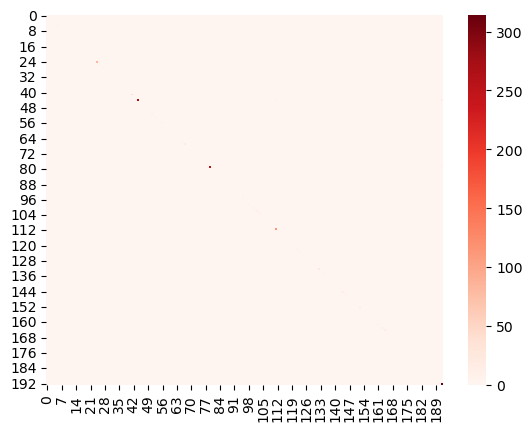

In [24]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
import seaborn as sns

y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)

y_pred_dense = np.argmax(y_pred, axis=1)
#f1 = f1_score(y_true, y_pred_dense, average='weighted')
accuracy = accuracy_score(y_true, y_pred_dense)
#recall = recall_score(y_true, y_pred_dense)

convergence = history.history['loss'][-1]

#Plot confusion matrics
cm = confusion_matrix(y_true, y_pred_dense)
sns.heatmap(cm, fmt='', cmap='Reds')

In [23]:
print(f"accuracy: {round (100* accuracy, 2)}, convergence : {round(convergence, 4)}")

accuracy: 92.99, convergence : 0.0611
